In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
b = BLEPipeline()

In [4]:
# b.extract_packet_features(create_master=True)

In [5]:
df = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


In [6]:
features_list = [
    # Packet info
    "PacketLength", "BLE_LL_Length", "Time", 
    
    # Associate Packets
    "Assoc_Packets",
    
    # Channel number
    "Channel_0", "Channel_12", "Channel_39",
    
    # PDU Type
    "SCAN_RSP", "ADV_IND", "SCAN_REQ", 
    "CONNECT_REQ", "ADV_NONCONN_IND", "ADV_DIRECT_IND"]

y_list = ["door", "lock", "temp"]

## Resample

### Downsampling

In [7]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'DeviceName', 'Set', 
                  'AccessAddr', 'AdvertAddr','PDUTypeNum'}
onehotEncoded_vars = {'ADV_DIRECT_IND', 'ADV_IND', 
                      'ADV_NONCONN_IND', 'ADV_SCAN_IND', 
                      'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP'}
response_vars = {"DeviceType","door","lock","temp"}
ble_devicetypes = ["door","lock","temp"]

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | onehotEncoded_vars
X = df_train.drop(col_drop, axis=1)

### Create trial dataframes

In [8]:
df_trials = []
num_trials = 10
while len(df_trials) != num_trials:
    df_downsampled = b.downsample(X, y, df[df["Set"]=="test"])

    # Ensure that the trial sample contains all features in feature list
    if set(features_list).issubset(set(df_downsampled.columns)):
        df_trials.append(df_downsampled)

## Run trials

In [9]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = b.one_vs_all_classify(trial, [x for x in features_list if x in trial.columns], y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports

### Plot ROC plots, report AUC

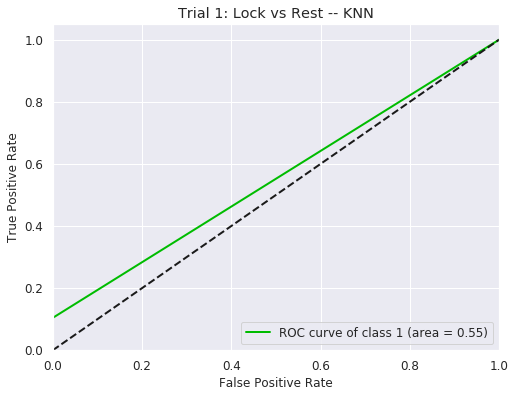

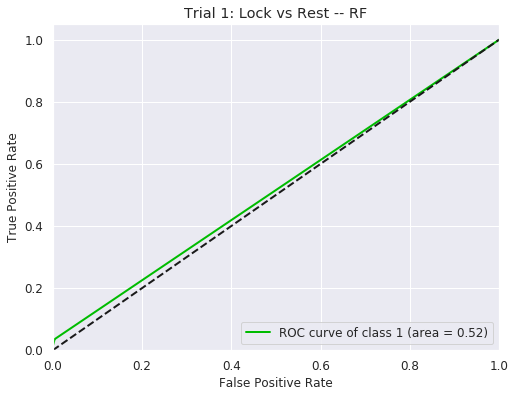

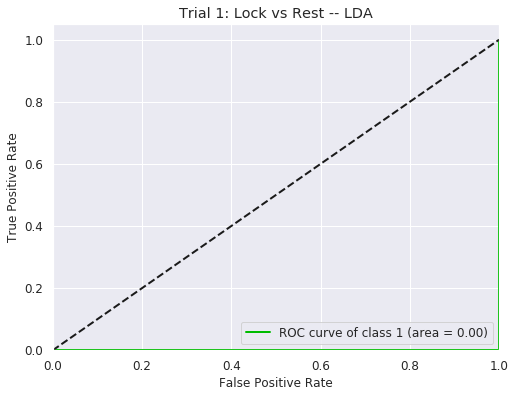

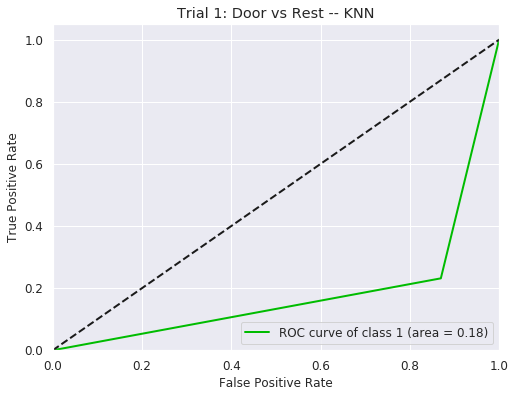

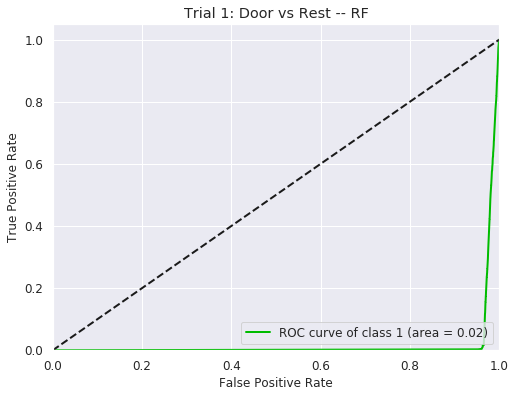

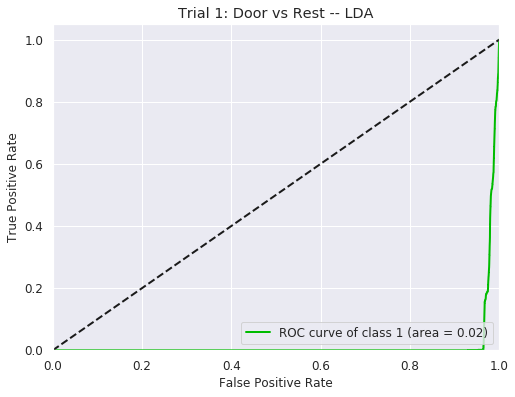

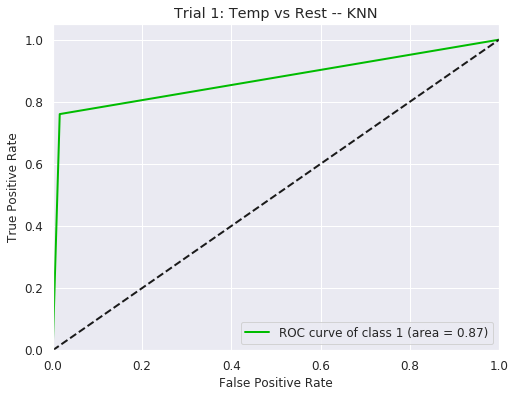

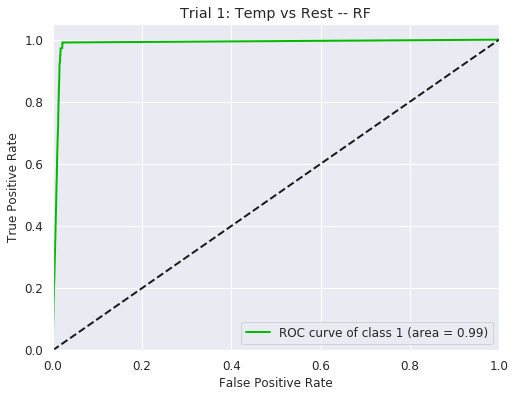

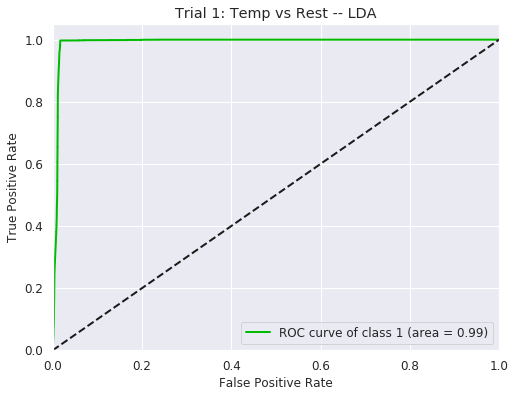

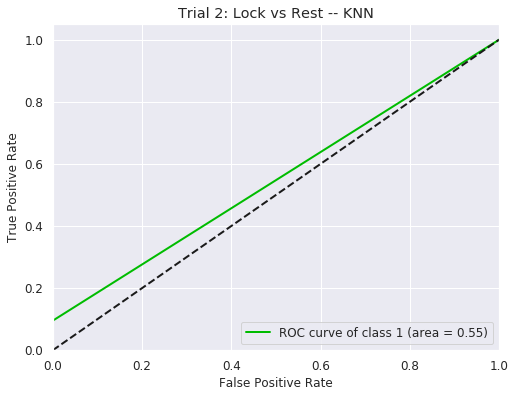

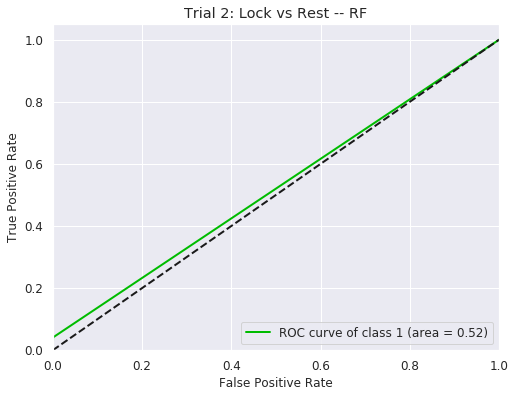

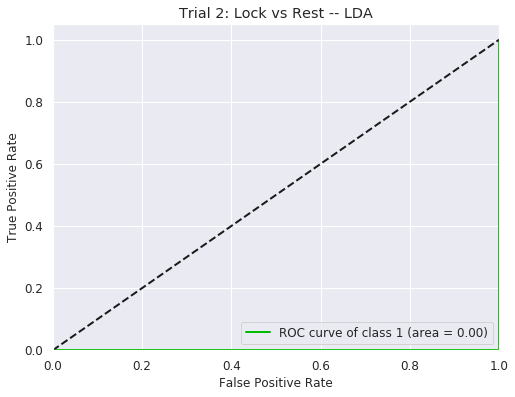

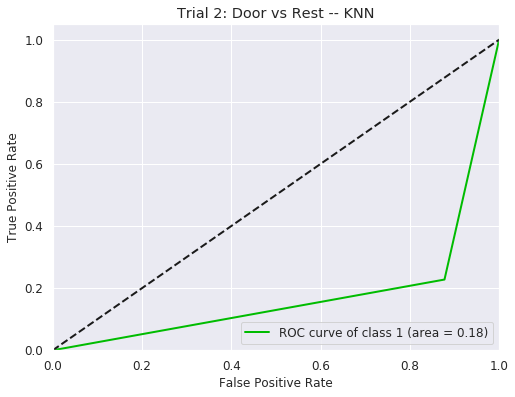

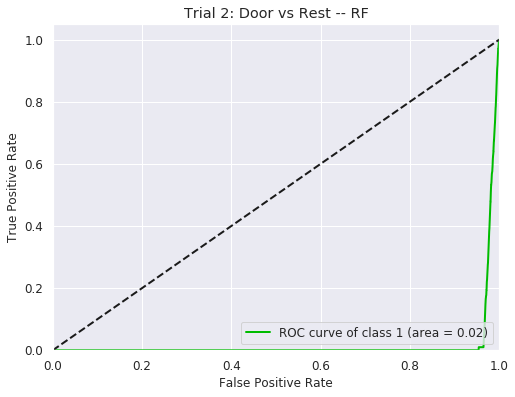

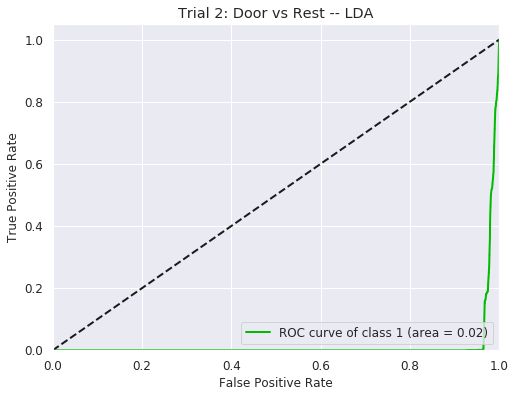

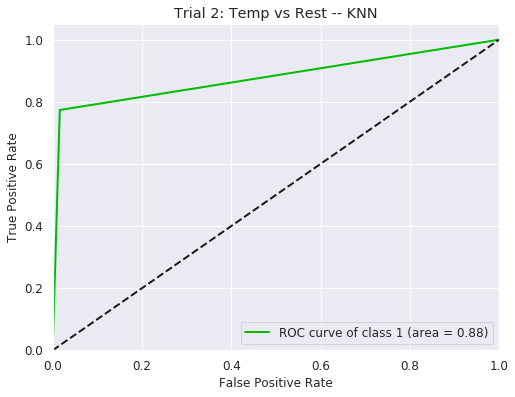

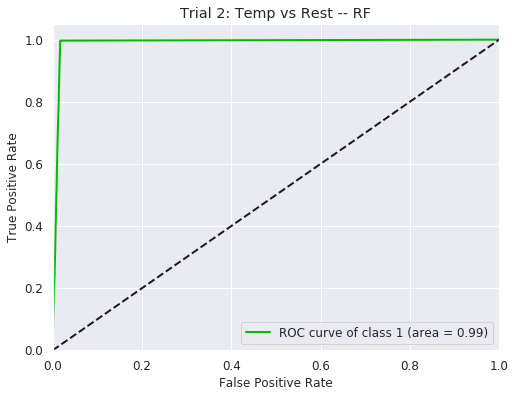

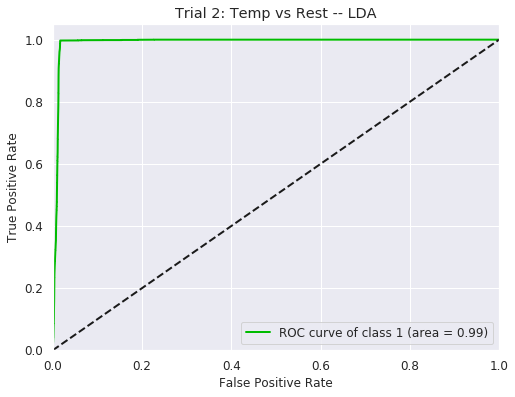

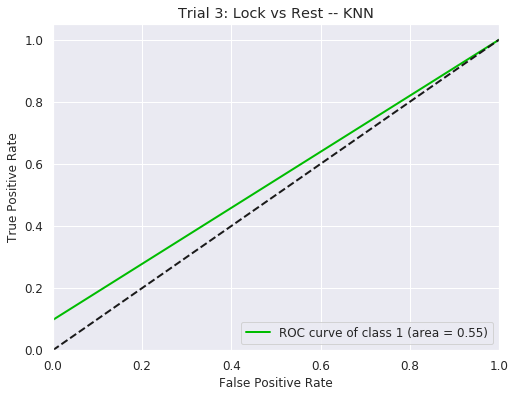

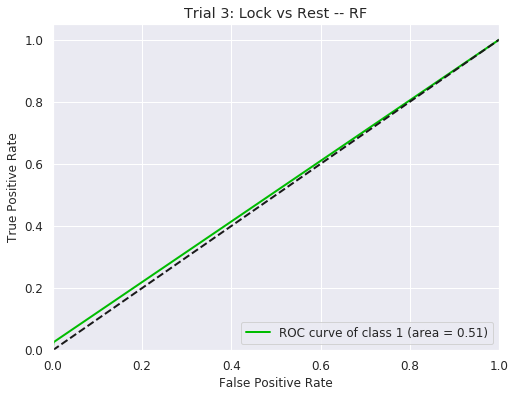

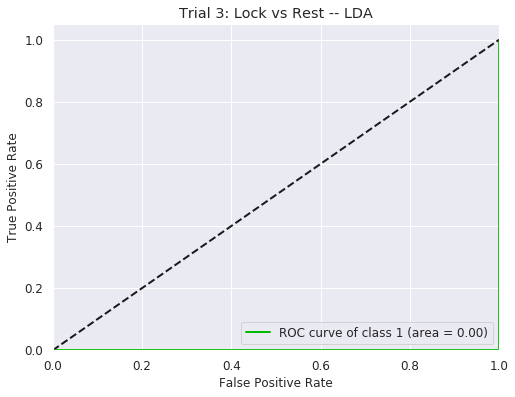

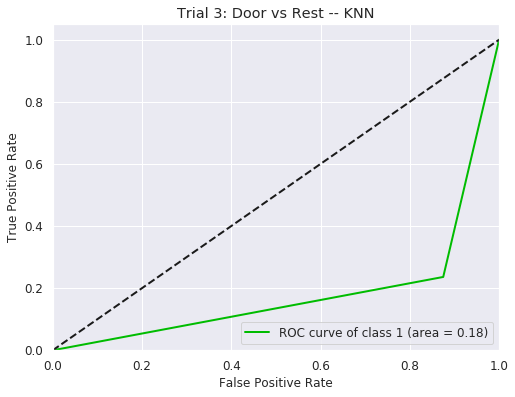

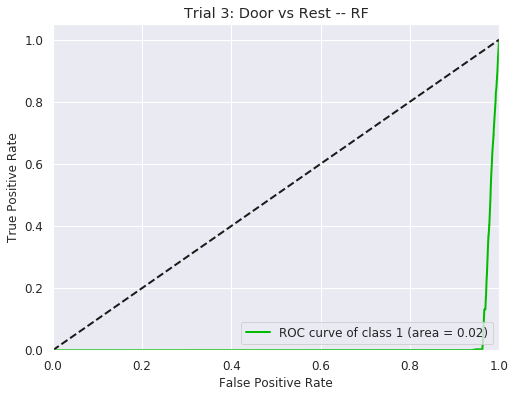

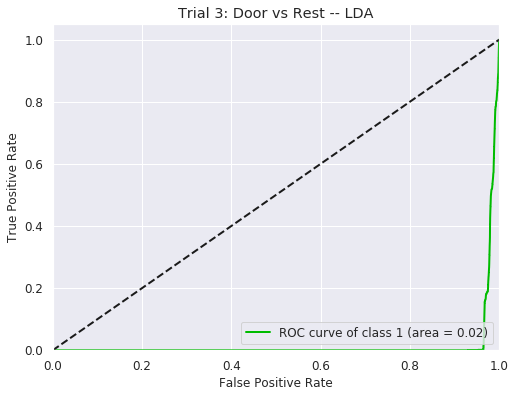

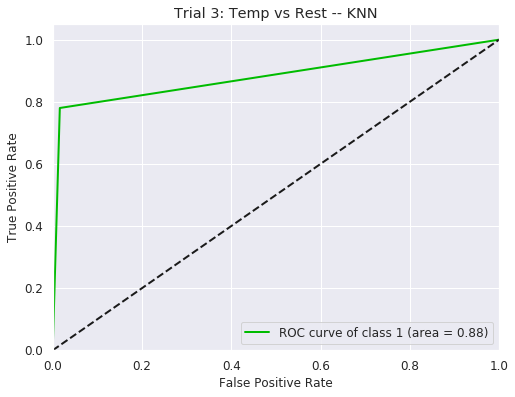

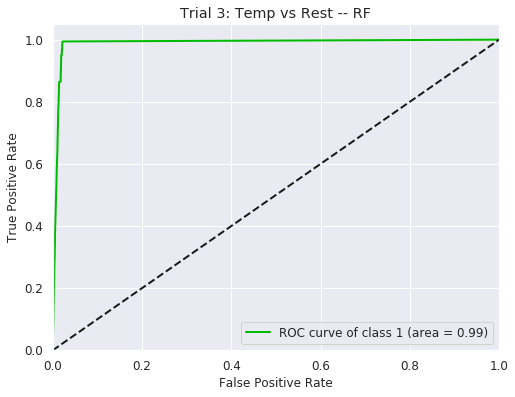

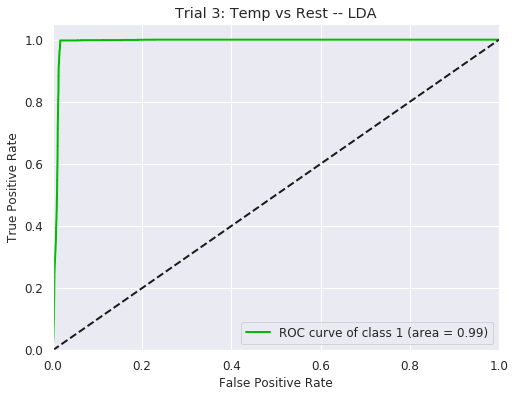

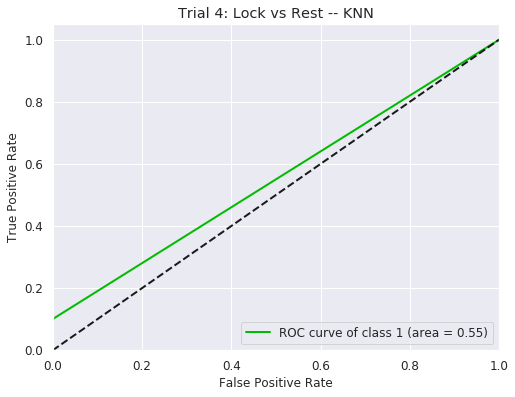

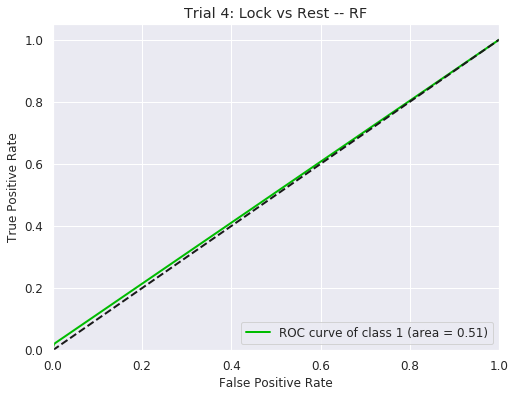

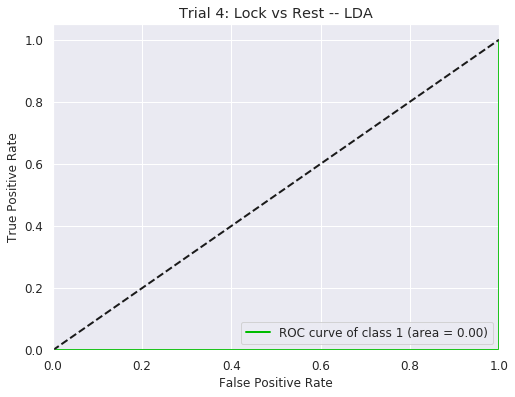

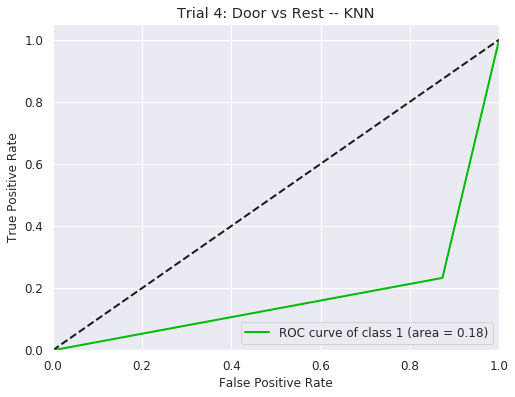

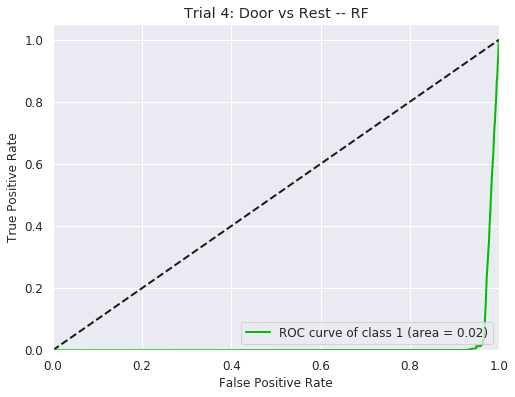

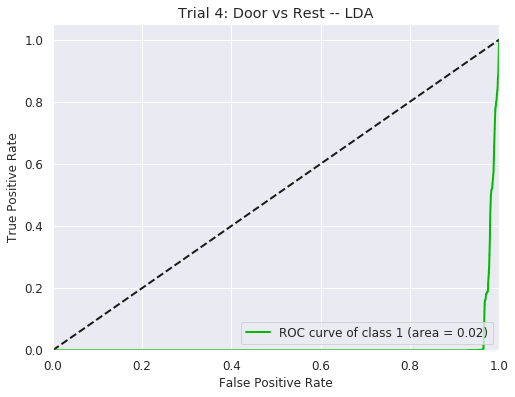

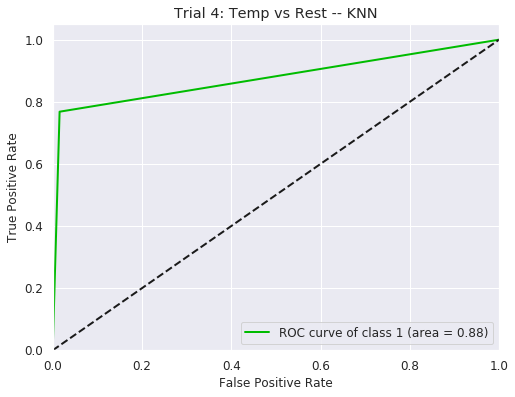

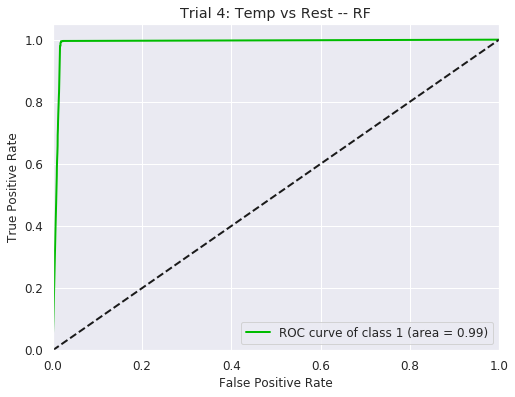

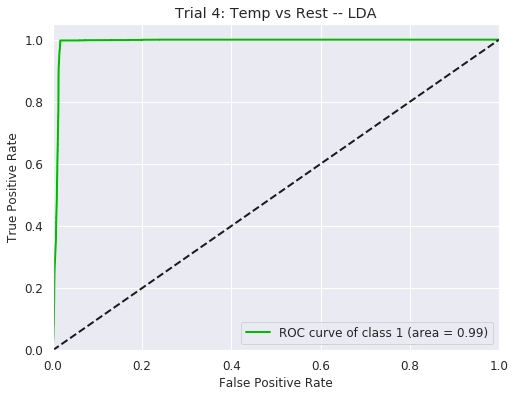

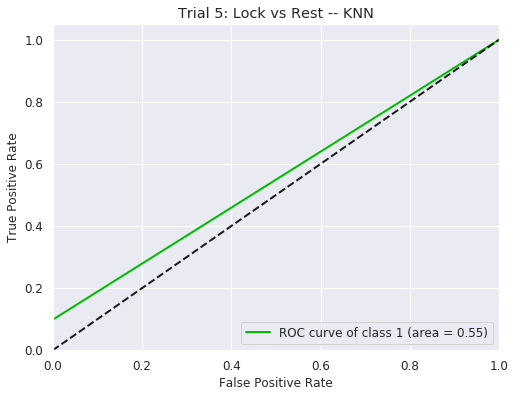

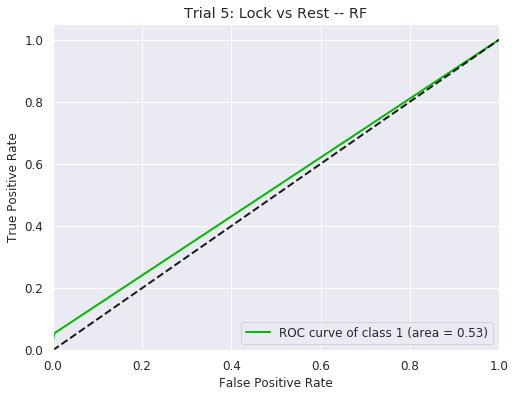

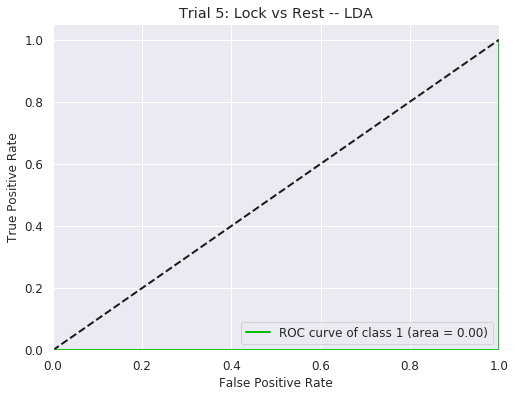

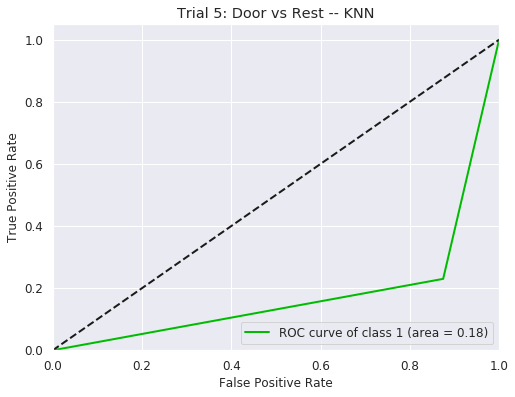

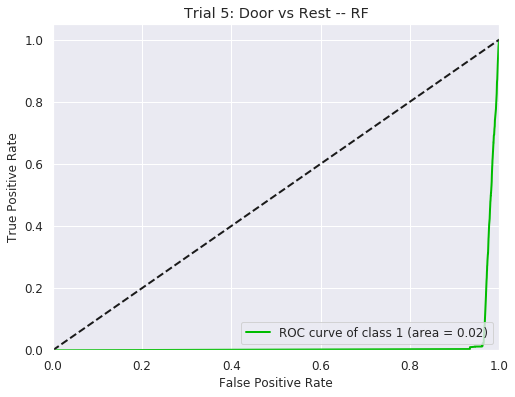

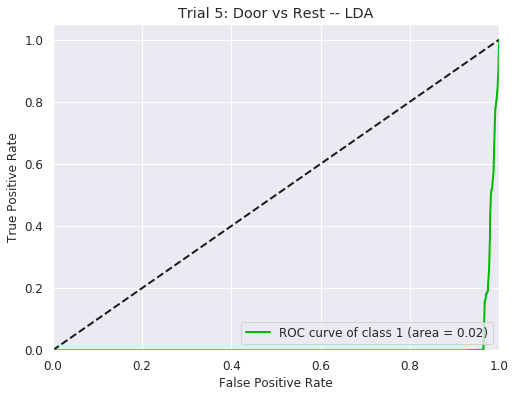

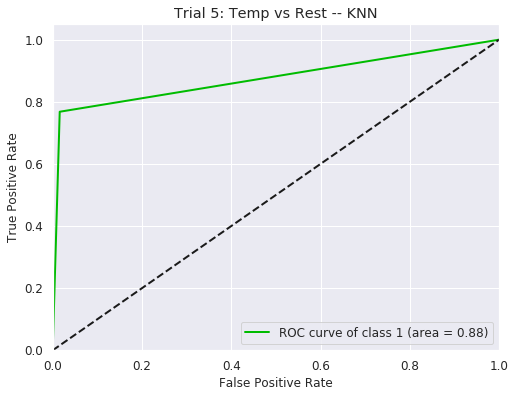

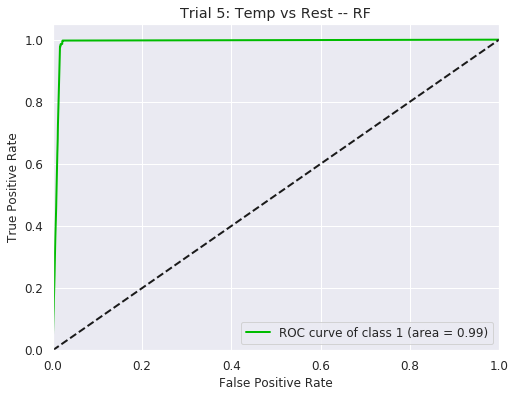

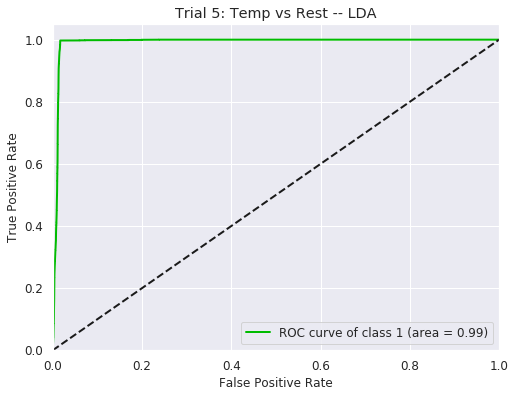

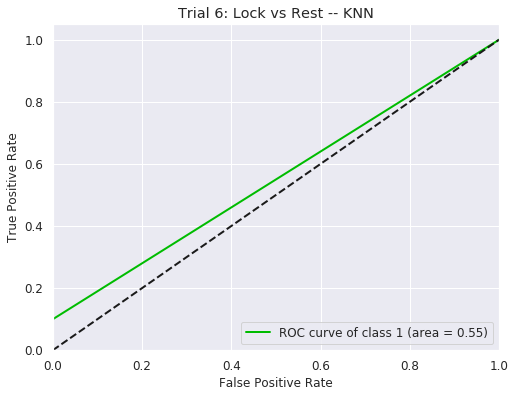

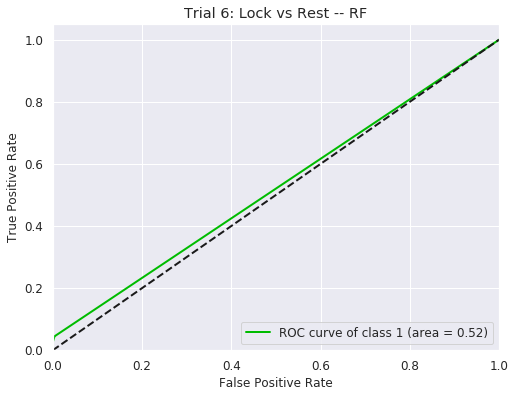

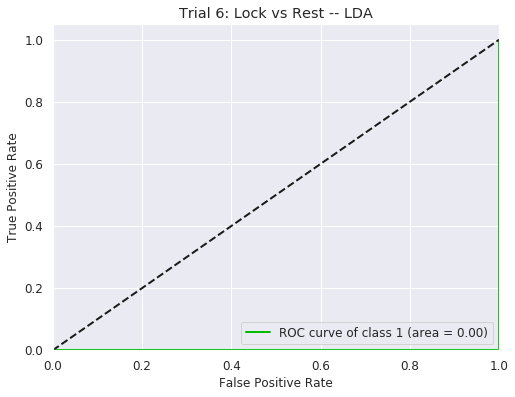

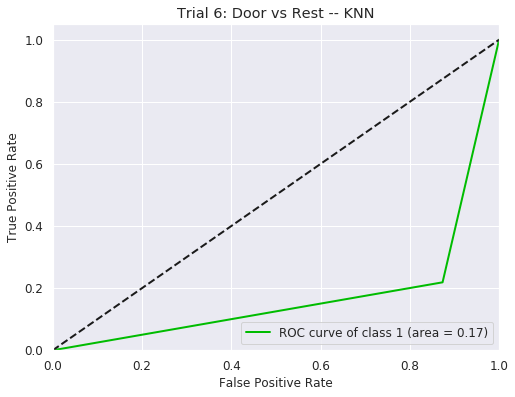

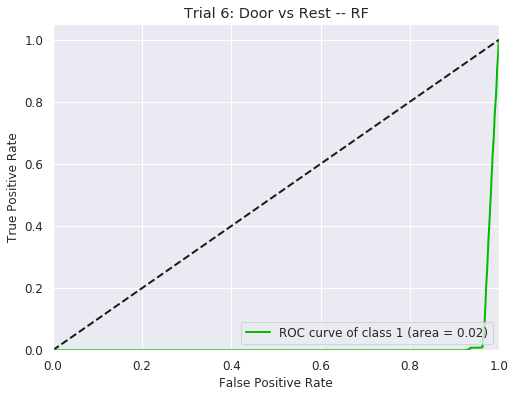

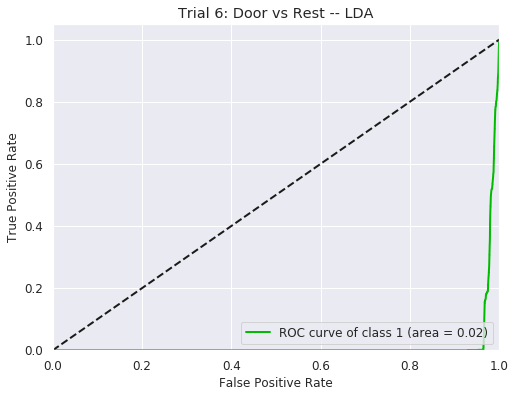

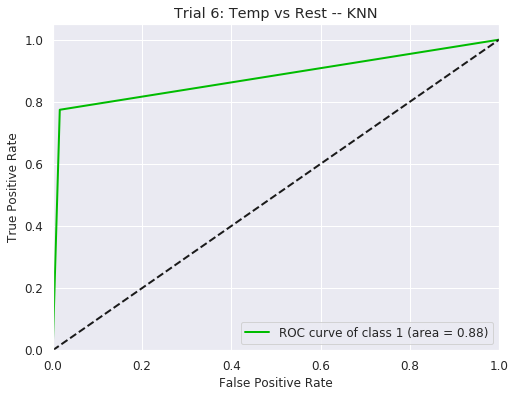

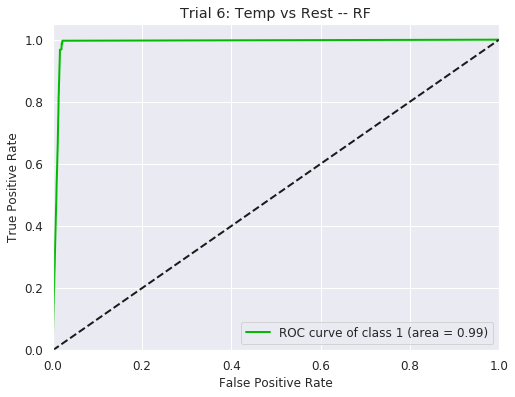

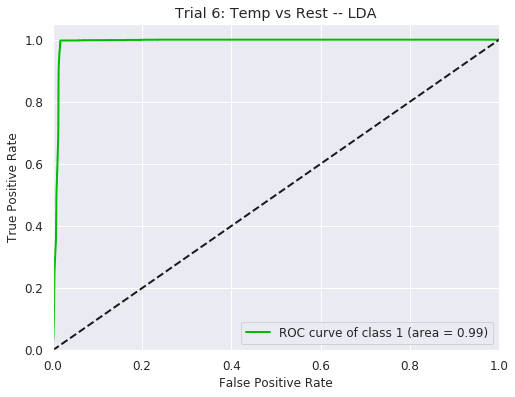

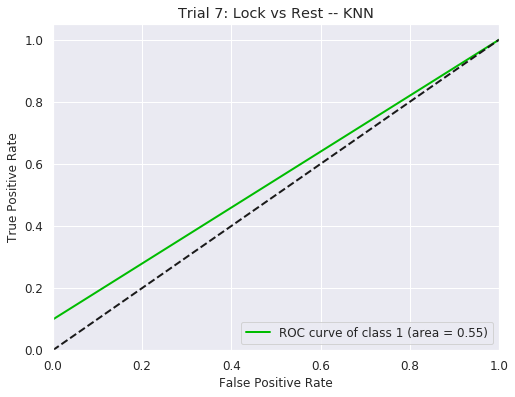

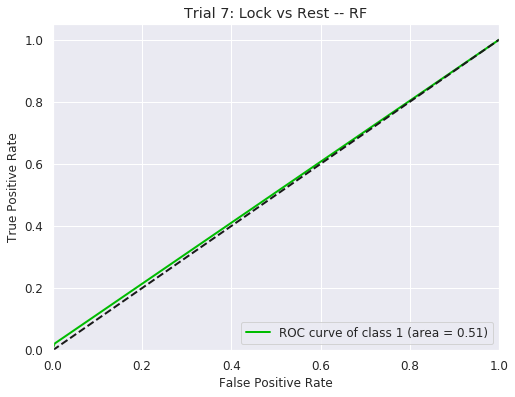

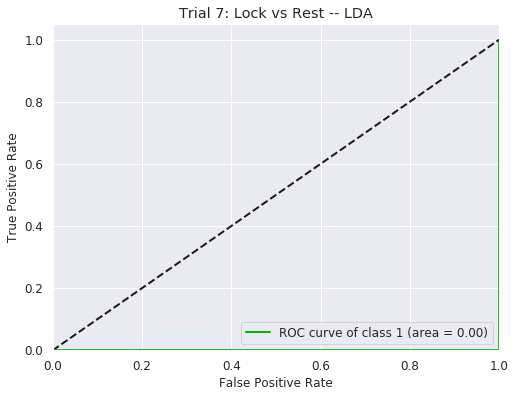

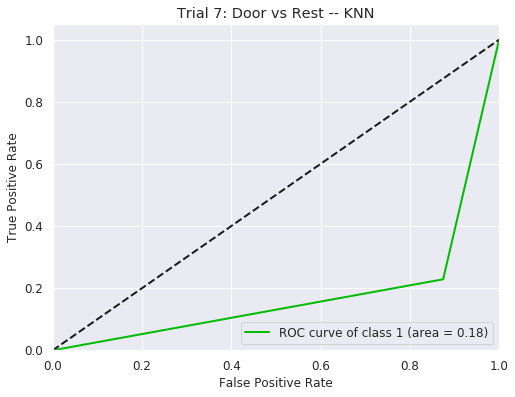

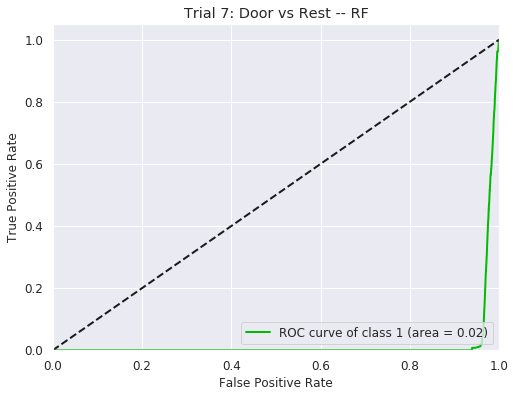

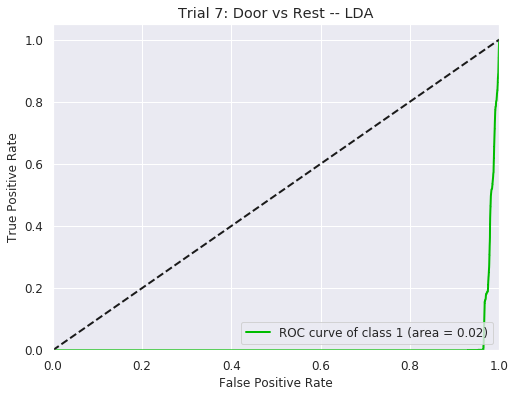

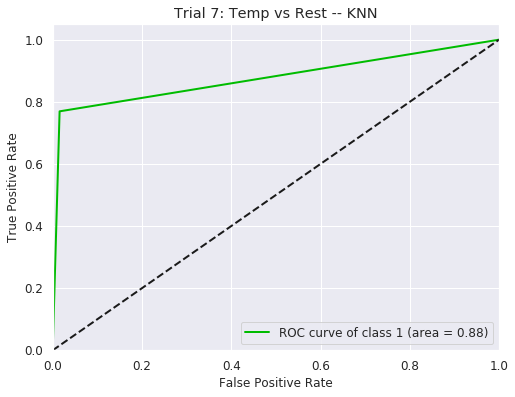

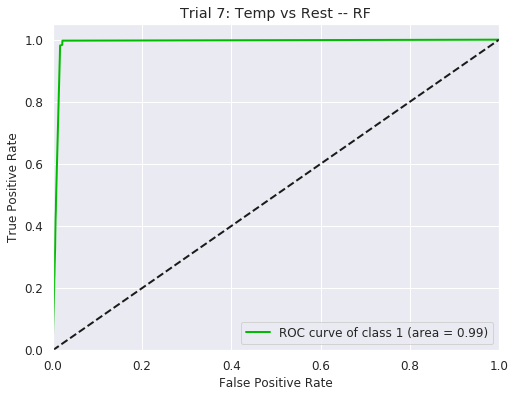

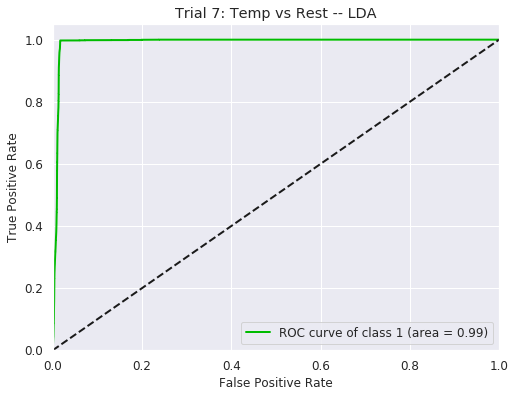

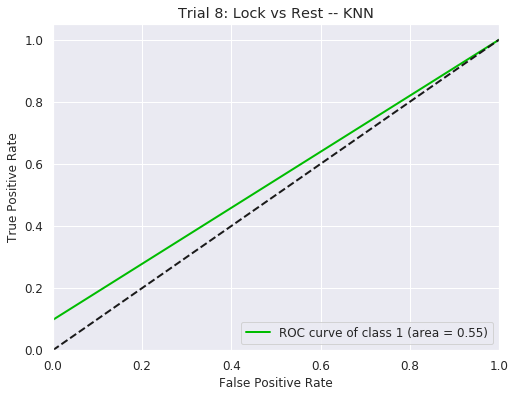

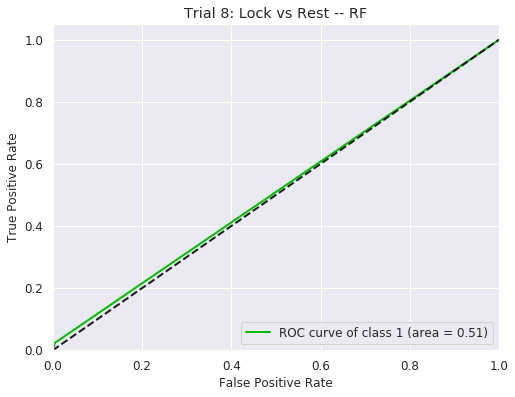

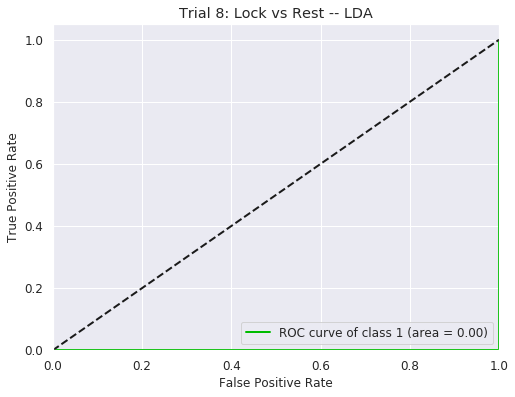

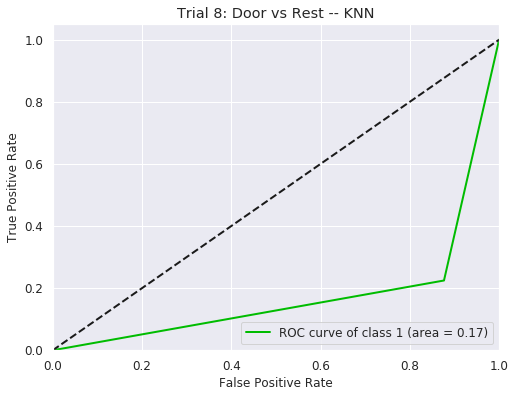

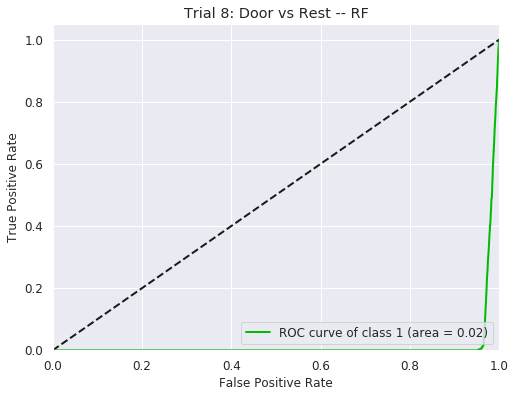

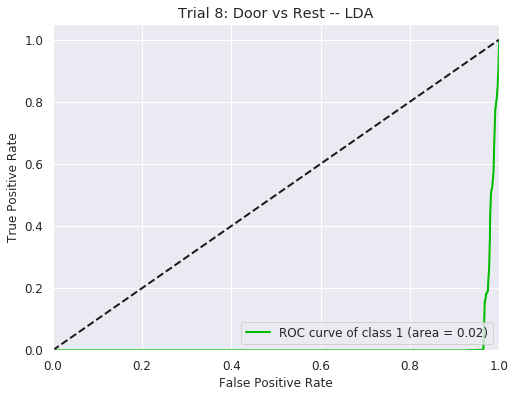

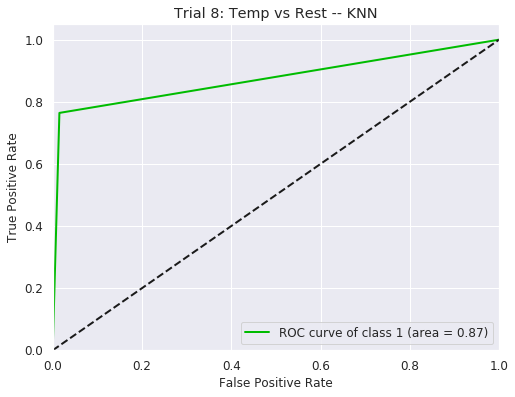

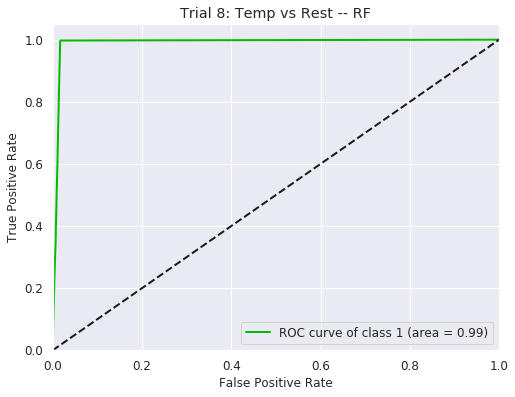

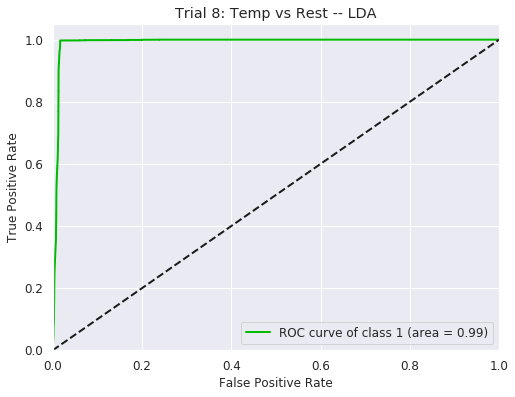

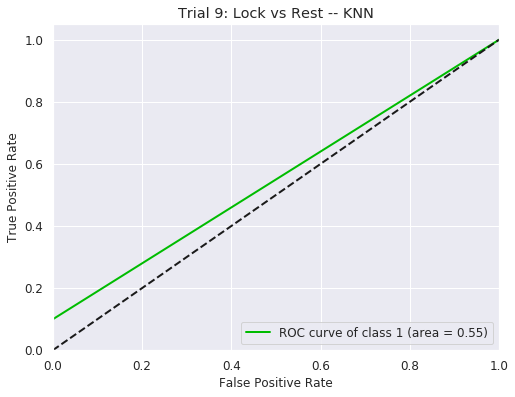

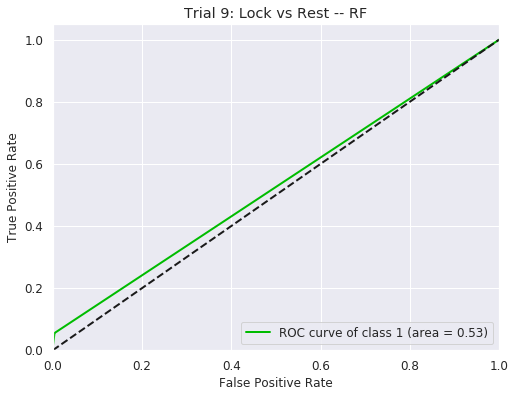

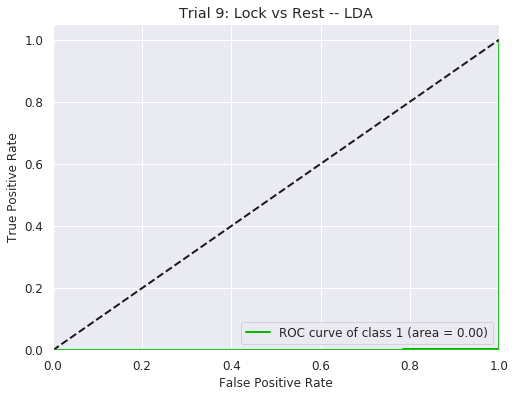

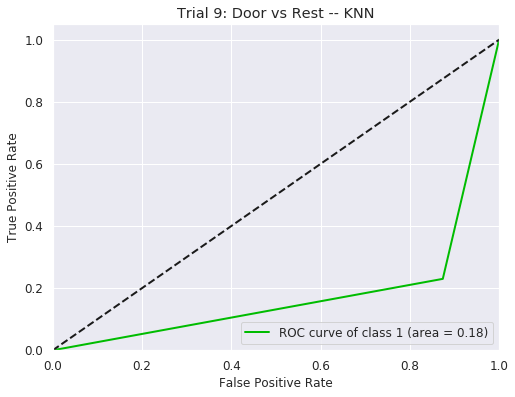

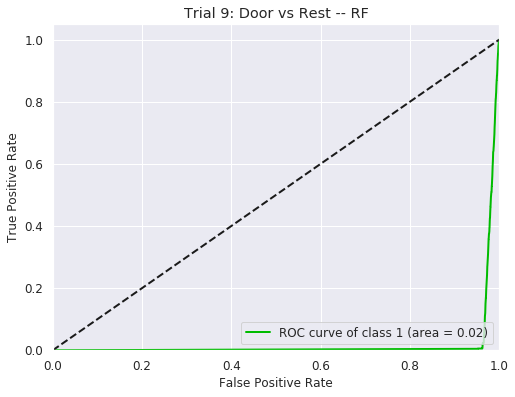

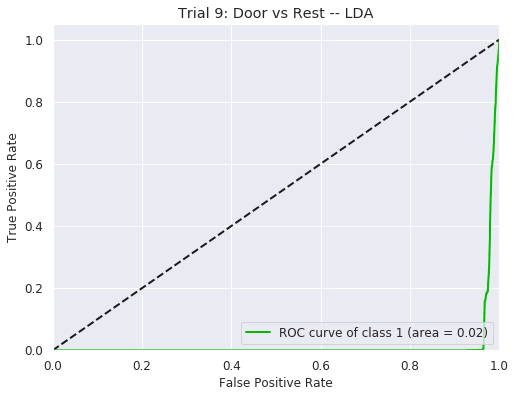

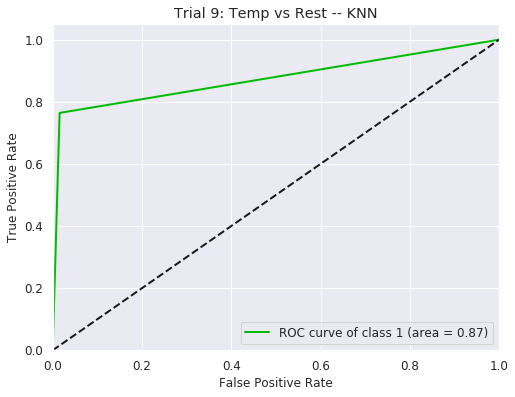

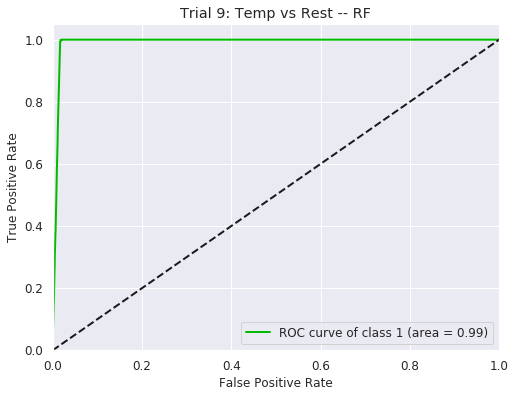

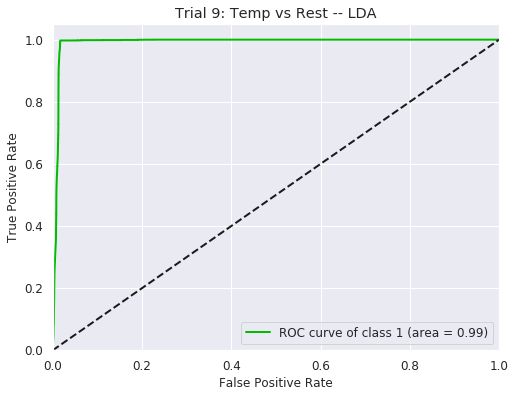

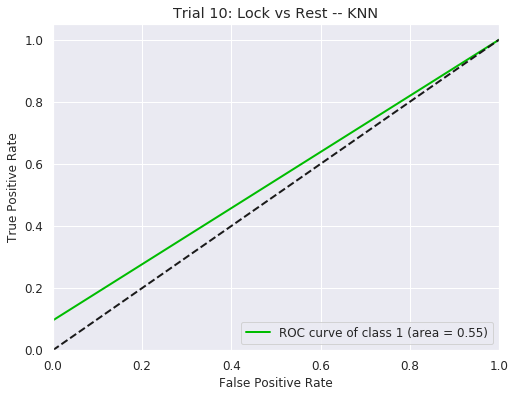

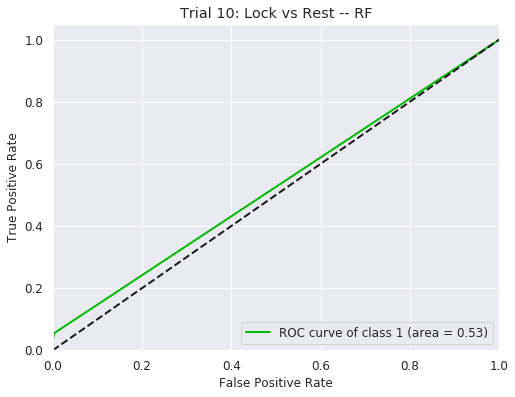

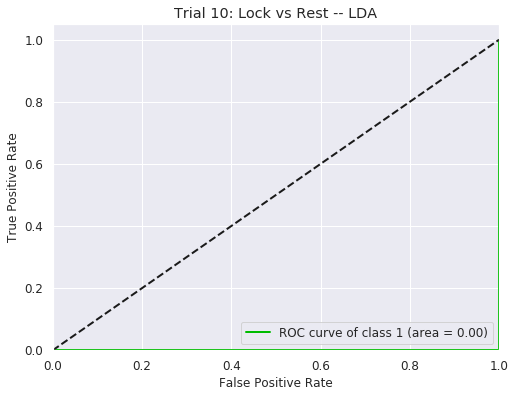

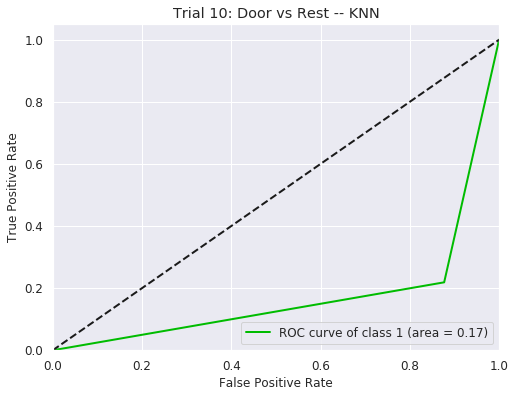

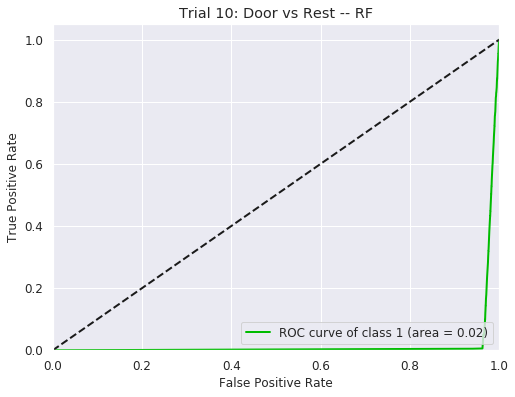

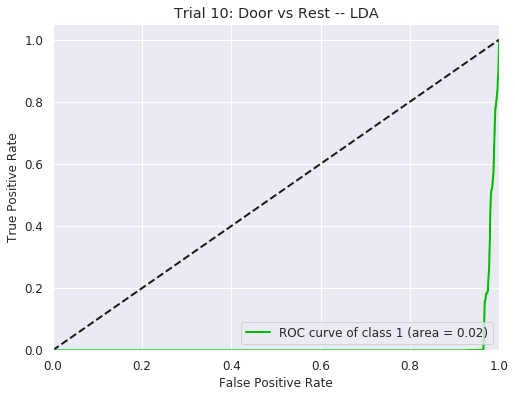

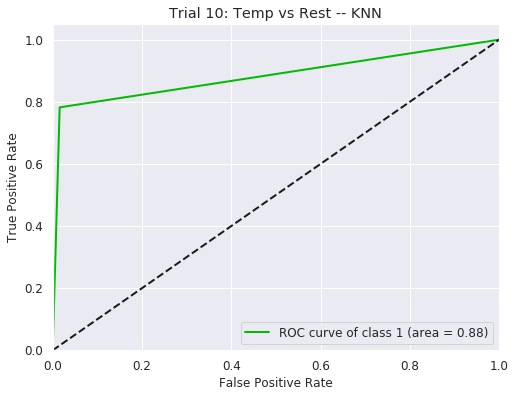

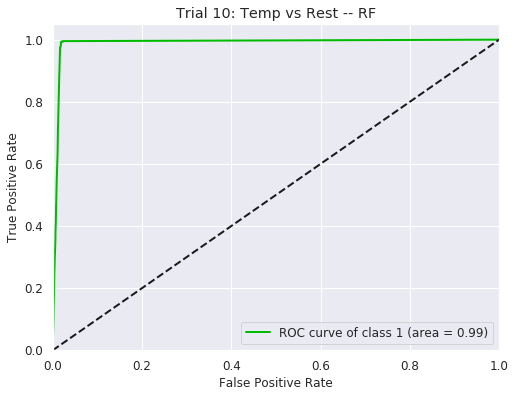

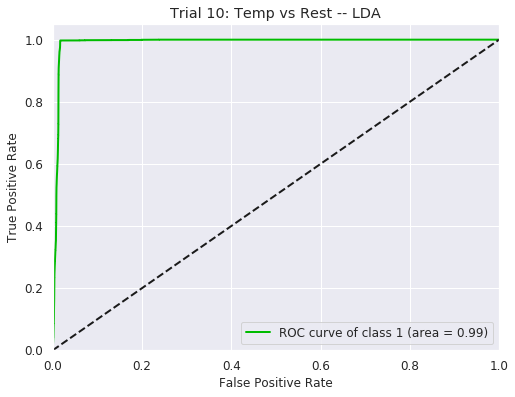

In [10]:
# Plotting ROC curves
sns.set(font_scale=1)
aucs = []
for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()
    
    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']

            # Calculate, store auc
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            aucs.append(auc)
            
            
            # Plot ROC curve
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));
            

### Print csv reports

In [11]:
df_alloutput = b.store_trial_results(trial_results)
df_alloutput['AUC'] = aucs
df_alloutput.to_csv('Results/ble-alltrials.csv', mode='w')

In [12]:
df_performance_device = b.report_metrics_across('Device', df_alloutput)
display(df_performance_device)
df_performance_device.to_csv('Results/ble-devtype-performance.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
lock,0.163515,0.119760,0.044478,0.136564,0.147178,0.054661,0.917166,0.118292,0.043933,0.355713,0.255892,0.095036
door,0.065555,0.044330,0.016464,0.092343,0.099128,0.036815,0.001700,0.001869,0.000694,0.070976,0.076093,0.028260
temp,0.974871,0.007255,0.002694,0.989324,0.007702,0.002860,0.985031,0.014426,0.005358,0.952782,0.054248,0.020147


In [13]:
df_performance_classifier = b.report_metrics_across('Classifier', df_alloutput)
display(df_performance_classifier)
df_performance_classifier.to_csv('Results/ble-devtype-classifier.csv', mode='w')

,Accuracy,SD_Accuracy,CI_Accuracy,Recall,SD_Recall,CI_Recall,Precision,SD_Precision,CI_Precision,AUC,SD_AUC,CI_AUC
KNN,0.416355,0.403253,0.149764,0.437168,0.397181,0.147509,0.665246,0.475387,0.176554,0.534509,0.291151,0.108131
RF,0.356227,0.450360,0.167260,0.343149,0.460995,0.171209,0.638482,0.468651,0.174053,0.508810,0.403014,0.149676
LDA,0.431359,0.403837,0.149981,0.437913,0.428959,0.159311,0.600167,0.436317,0.162044,0.336152,0.471134,0.174975


### Time Performance

In [14]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in y_list:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 24.0783059597 seconds
(Door, KNN) : 5.00512599945 seconds
(Door, RF) : 1.27815794945 seconds
(Door, LDA) : 0.652024030685 seconds
(Lock, KNN) : 4.89812493324 seconds
(Lock, RF) : 1.13835692406 seconds
(Lock, LDA) : 0.65293097496 seconds
(Temp, KNN) : 4.91224384308 seconds
(Temp, RF) : 1.17390608788 seconds
(Temp, LDA) : 0.652980089188 seconds

Trial  1
Total time: 23.7821269035 seconds
(Door, KNN) : 4.8671131134 seconds
(Door, RF) : 1.28136706352 seconds
(Door, LDA) : 0.6854429245 seconds
(Lock, KNN) : 4.86048293114 seconds
(Lock, RF) : 1.12850809097 seconds
(Lock, LDA) : 0.648251056671 seconds
(Temp, KNN) : 4.79913401604 seconds
(Temp, RF) : 1.16701292992 seconds
(Temp, LDA) : 0.64350605011 seconds

Trial  2
Total time: 24.1355922222 seconds
(Door, KNN) : 4.9269618988 seconds
(Door, RF) : 1.27700710297 seconds
(Door, LDA) : 0.673742055893 seconds
(Lock, KNN) : 4.89589595795 seconds
(Lock, RF) : 1.13777017593 seconds
(Lock, LDA) : 0.677996873856 seconds
(Temp, KNN)

### Feature Importance

In [15]:
df_featImp = pd.DataFrame()
for i,f in enumerate(b.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [16]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [17]:
feat_imp = df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False)
display(feat_imp)
feat_imp.to_csv('Results/ble-feature_importance.csv', mode='w')

,Mean,StdDev,CI_MOE
PacketLength,0.283282,0.138953,0.080224
BLE_LL_Length,0.263396,0.132490,0.076493
SCAN_RSP,0.195288,0.148004,0.085450
Assoc_Packets,0.145904,0.097537,0.056313
ADV_IND,0.087854,0.049491,0.028574
SCAN_REQ,0.017618,0.019522,0.011271
Time,0.005971,0.003797,0.002192
Channel_12,0.000344,0.000621,0.000358
Channel_39,0.000186,0.000366,0.000211
Channel_0,0.000075,0.000050,0.000029


### Plots

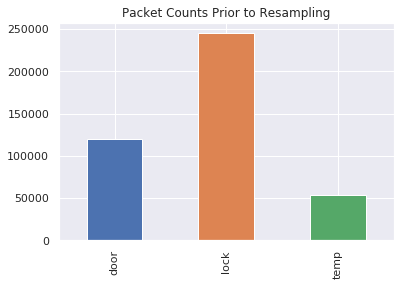

In [18]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

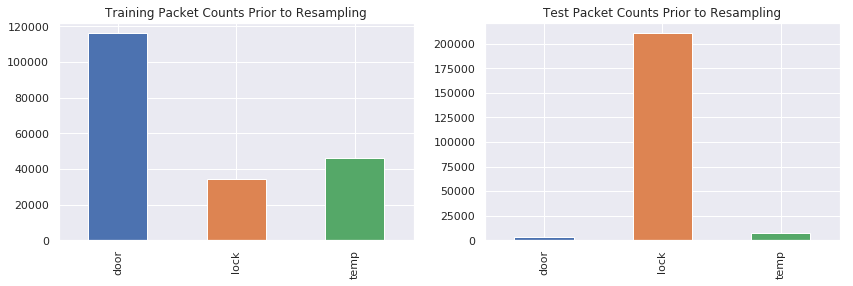

In [19]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


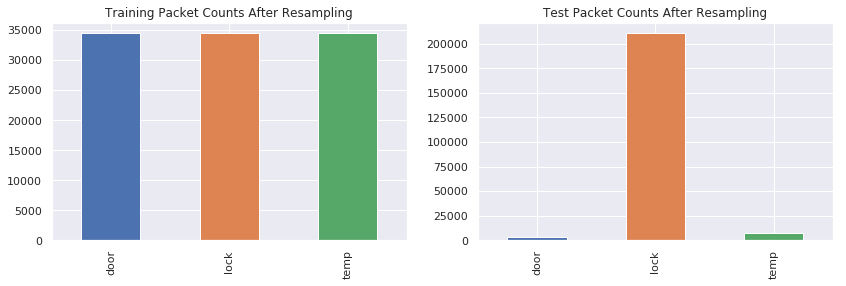

In [20]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[ble_devicetypes].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
